# Modeling the Spread and Detection of Fake News in Social Media: Centralized, Crowdsourced, and Hybrid Strategies
_Authors: Beatriz Enríquez, Daniel Arias & Zehra Özeren_

## Introduction
The rapid spread of fake news on social media has become a pressing issue with significant social implications. The dissemination of misinformation can influence public opinion, interfere with democratic processes, and contribute to the polarization of communities [1]. Traditionally, social media platforms have relied on professional fact-checkers to review and label misleading content [2], such as AFP USA, Check Your Fact, Factcheck.org, Lead Stories, PolitiFact, Science Feedback, Reuters Fact Check, TelevisaUnivision, The Dispatch and USA TODAY.

However, new approaches are being explored. One such approach is the crowdsourced model (also knows as Community Notes), in which users themselves participate in the identification and contextualization of potentially misleading content. This method has gained traction on platforms such as X (formerly Twitter), where users contribute to a collective fact-checking process. Meta, the parent company of Facebook and Instagram, has also announced plans to move toward this model [3], signaling a shift from centralized moderation to decentralized, community-driven verification.

From a complex network perspective, this problem is particularly intriguing. Social networks can be represented as graphs, where nodes correspond to users and edges to interactions or relationships. By modeling different strategies for fake news detection and mitigation, we can evaluate their effectiveness and robustness under various network conditions.

## Project Objectives and Methodology
The goal of this project is to study the propagation of fake news through complex networks and to compare the effectiveness of different detection and mitigation strategies. We propose to develop and simulate three distinct models:

- **Centralized Detection Model**: In this model, a subset of nodes is designated as professional or algorithmic fact-checkers. These nodes are responsible for identifying and stopping the spread of fake news. This setup simulates the traditional centralized approach used by platforms such as Facebook prior to the shift to crowdsourcing.

- **Crowdsourced Detection Model**: Here, the entire network is involved in the verification process. Each node (user) has the ability to vote on the veracity of a piece of information. The propagation of fake news depends on the collective response of the network. This model represents the new paradigm being explored by platforms like Meta and X.

- **Hybrid Model**: Inspired by recent academic proposals [4], this model combines the previous two approaches. A small group of expert nodes works alongside the crowd to evaluate the information. The final decision on the truthfulness of the news is based on a weighted combination of expert opinion and crowd consensus.

Each model will be implemented and tested on synthetic networks (e.g., Barabasi-Albert) to assess their behavior under different topologies. Key metrics such as speed of propagation, fraction of nodes exposed to fake news, and effectiveness in containing misinformation will be analyzed.

The results of this study could provide insight into the trade-offs between centralized and decentralized moderation, and how network structure influences the spread and detection of fake news.

## 1. Centralized Detection Model

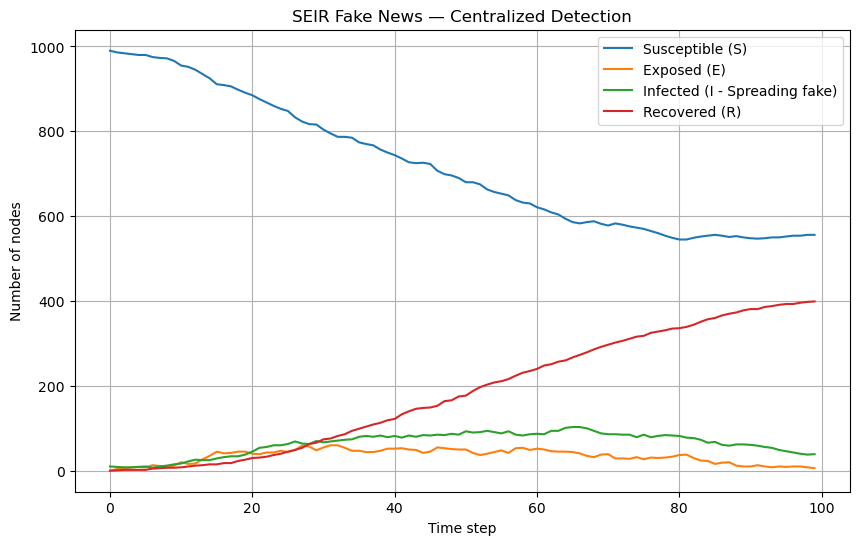

In [1]:
from seir_model import simulate_seir, plot_seir
import networkx as nx
import numpy as np

N = 1000
G = nx.barabasi_albert_graph(N, 3)

beta = 0.03
delta = 0.2
gamma = 0.1
alpha = 0.6

eta = np.zeros(N)
fact_checkers = np.random.choice(N, size=int(0.1 * N), replace=False)
eta[fact_checkers] = 1.0

initial_state = {node: 'I' for node in np.random.choice(G.nodes, size=10, replace=False)}
history = simulate_seir(G, beta, delta, gamma, alpha, eta, initial_state)
plot_seir(history, title='SEIR Fake News — Centralized Detection')


## 2. Crowsourced Detection Model

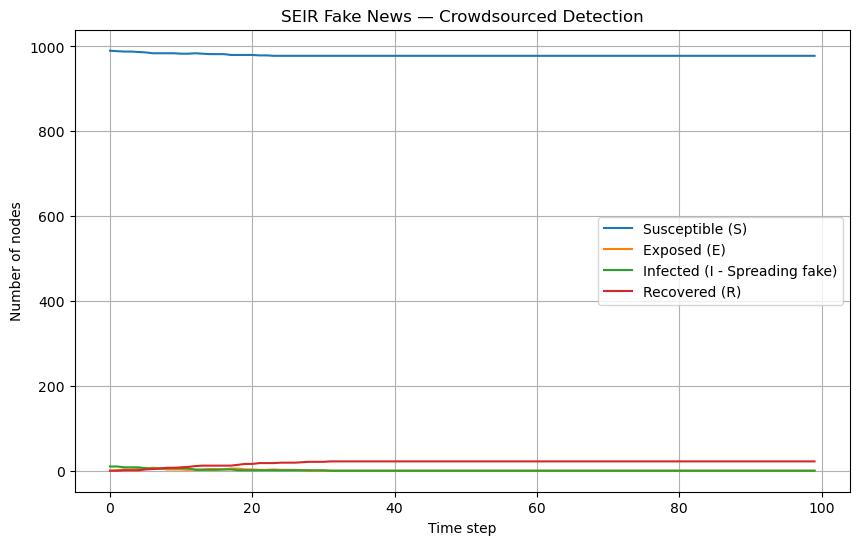

In [2]:
from seir_model import simulate_seir, plot_seir
import networkx as nx
import numpy as np

N = 1000
G = nx.barabasi_albert_graph(N, 3)

beta = 0.03
delta = 0.2
gamma = 0.1
alpha = 0.6

eta = np.full(N, 0.6)  # todos los nodos tienen la misma capacidad de detección

initial_state = {node: 'I' for node in np.random.choice(G.nodes, size=10, replace=False)}
history = simulate_seir(G, beta, delta, gamma, alpha, eta, initial_state)
plot_seir(history, title='SEIR Fake News — Crowdsourced Detection')


## 3. Hybrid Detection Model

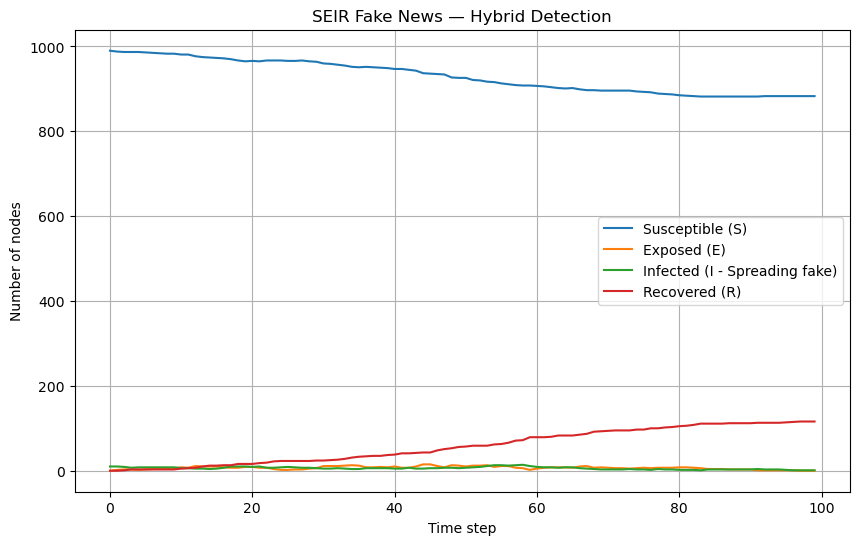

In [3]:
from seir_model import simulate_seir, plot_seir
import networkx as nx
import numpy as np

N = 1000
G = nx.barabasi_albert_graph(N, 3)

beta = 0.03
delta = 0.2
gamma = 0.1
alpha = 0.6

eta = np.full(N, 0.5)
experts = np.random.choice(N, size=int(0.05 * N), replace=False)
eta[experts] = 1.0  # nodos expertos

initial_state = {node: 'I' for node in np.random.choice(G.nodes, size=10, replace=False)}
history = simulate_seir(G, beta, delta, gamma, alpha, eta, initial_state)
plot_seir(history, title='SEIR Fake News — Hybrid Detection')


## References
[1] J. Thebault-Spieker, S. Venkatagiri, N. Mine, and K. Luther, “Diverse perspectives can mitigate political bias in crowdsourced content moderation,” in 2023 ACM Conference on Fairness Accountability and Transparency, ser. FAccT ’23. ACM, Jun. 2023, p. 1280–1291. [Online]. Available: http://dx.doi.org/10.1145/3593013.3594080

[2] M. T. Center, “How fact-checking works,” 2025, accessed: May 6, 2025. [Online]. Available: https://transparency.meta.com/en-gb/features/how-fact-checking-works/

[3] C. G. A. O. Joel Kaplan, “More speech and fewer mistakes,” 2025, accessed: May 6, 2025. [Online]. Available: https://about.fb.com/news/2025/01/meta-more-speech-fewer-mistakes/